In [1]:
import os

os.environ["PATH"] += os.pathsep + "/usr/local/cuda-11.2/bin/"
if "LD_LIBRARY_PATH" in os.environ:
    os.environ["LD_LIBRARY_PATH"] += os.pathsep + "/usr/local/cuda-11.2/lib64"
else:
    os.environ["LD_LIBRARY_PATH"] = (
        "/usr/local/cuda-11.2/lib64/" + os.pathsep + "/usr/local/cuda/lib64"
    )
os.environ["CUDA_HOME"] = "/usr/local/cuda-11.2"
os.environ["CUDADIR"] = "/usr/local/cuda-11.2"

In [2]:
import numpy as np

print(os.environ["PATH"])
print(os.environ["LD_LIBRARY_PATH"])
print(os.environ["CUDADIR"])

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
from tensorflow_examples.lite.model_maker.third_party.efficientdet.keras import train
from tensorflow_examples.lite.model_maker.third_party.efficientdet.keras import (
    train_lib,
)

import tensorflow as tf

assert tf.__version__.startswith("2")

tf.get_logger().setLevel("ERROR")
from absl import logging

logging.set_verbosity(logging.ERROR)

/home/dino/miniconda3/envs/tfl/bin:/home/dino/.vscode-server/bin/b58957e67ee1e712cebf466b995adf4c5307b2bd/bin/remote-cli:/home/dino/.local/bin:/home/dino/miniconda3/condabin:/home/dino/.nvm/versions/node/v16.15.1/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/lib/wsl/lib:/mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.3/bin:/mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.3/libnvvp:/mnt/c/Program Files/Zulu/zulu-8/bin:/mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common:/mnt/c/Program Files/NVIDIA/CUDNN/v8.8/bin:/mnt/c/Program Files/ImageMagick-7.1.1-Q16-HDRI:/mnt/c/Program Files/Oculus/Support/oculus-runtime:/mnt/c/Python38/Scripts:/mnt/c/Python38:/mnt/c/Program Files (x86)/Python38-32/Scripts:/mnt/c/Program Files (x86)/Python38-32:/mnt/c/Program Files (x86)/Common Files/Intel/Shared Libraries/redist/intel64/compiler:/mnt/c/Windows/system32:/mnt/c/Windows:/mnt/c/Windows/System32/Wbem:/mnt/c/Windows/System32/

/home/dino/miniconda3/envs/tfl/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/dino/miniconda3/envs/tfl/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an iss

In [3]:
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf

assert tf.__version__.startswith("2")

tf.get_logger().setLevel("ERROR")
from absl import logging

logging.set_verbosity(logging.ERROR)

In [4]:
# Check GPU
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

GPU is available


2024-05-04 14:17:07.619031: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 14:17:07.920948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 14:17:07.941986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 14:17:07.942296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built witho

In [5]:
class_map = {
    1: "box",
    2: "green_light",
    3: "left_arrow",
    4: "no_light",
    5: "person",
    6: "red_light",
    7: "right_arrow",
    8: "tree",
    9: "unknown_arrow",
}

In [6]:
train_data = object_detector.DataLoader.from_pascal_voc(
    images_dir="label_data/pascal/training/images",
    annotations_dir="label_data/pascal/training/Annotations",
    label_map=class_map,
)

validation_data = object_detector.DataLoader.from_pascal_voc(
    images_dir="label_data/pascal/validation/images",
    annotations_dir="label_data/pascal/validation/Annotations",
    label_map=class_map,
)
print(f"train count: {len(train_data)}")
print(f"validation count: {len(validation_data)}")

train count: 4875
validation count: 667


In [7]:
batch_size = 4
epochs = 50

hparams = {
    "input_rand_hflip": False,
    "jitter_min": 0.8,
    "jitter_max": 1.2,
    "autoaugment_policy": "v0",
}

spec = object_detector.EfficientDetLite1Spec(
    model_dir="tfl/efficientdet_lite1",
    epochs=epochs,
    batch_size=batch_size,
    hparams=hparams,
    tflite_max_detections=25,
)

2024-05-04 14:17:11.575665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 14:17:11.576098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 14:17:11.576465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 14:17:11.577434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 14:17:11.577739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not op

In [8]:
detector = object_detector.create(
    train_data,
    model_spec=spec,
    batch_size=batch_size,
    train_whole_model=True,
    validation_data=validation_data,
    epochs=epochs,
    do_train=False,
)

In [9]:
train_ds, steps_per_epoch, _ = detector._get_dataset_and_steps(
    train_data, batch_size, is_training=True
)
validation_ds, validation_steps, val_json_file = detector._get_dataset_and_steps(
    validation_data, batch_size, is_training=False
)

In [10]:
model = detector.create_model()

In [11]:
config = spec.config
config.update(
    dict(
        steps_per_epoch=steps_per_epoch,
        eval_samples=batch_size * validation_steps,
        val_json_file=val_json_file,
        batch_size=batch_size,
    )
)

train.setup_model(model, config)

model.summary()

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  multiple                  4234512   
                                                                 
 class_net/class-predict (Se  multiple                 8001      
 parableConv2D)                                                  
                                                                 
 box_net/box-predict (Separa  multiple                 3996      
 bleConv2D)                                                      
                                                                 
Total params: 4,246,509
Trainable params: 4,183,437
Non-trainable params: 63,072
_________________________________________________________________


In [12]:
checkpoint_dir = "tfl/efficientdet_lite1"
try:
    latest = tf.train.latest_checkpoint(checkpoint_dir)

    # latest = checkpoint_dir

    completed_epochs = int(latest.split("/")[-1].split("-")[1])
    model.load_weights(latest)

    print(f"Loaded model from {latest}")
except Exception as e:
    print(f"Failed to load model: {e}")
    completed_epochs = 0

Loaded model from tfl/efficientdet_lite1/ckpt-5


In [13]:
all_callbacks = train_lib.get_callbacks(config.as_dict(), validation_ds)

In [14]:
all_callbacks.append(
    tf.keras.callbacks.TensorBoard(log_dir="tfl/efficientdet_lite1/logs")
)

In [15]:
model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_ds,
    validation_steps=validation_steps,
    callbacks=all_callbacks,
    initial_epoch=completed_epochs,
)

Epoch 6/50


2024-05-04 14:18:01.101078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


1218/1218 [==============================] - 514s 397ms/step - det_loss: 0.2904 - cls_loss: 0.1935 - box_loss: 0.0019 - reg_l2_loss: 0.0742 - loss: 0.3646 - learning_rate: 0.0048 - gradient_norm: 2.6148 - val_det_loss: 0.1460 - val_cls_loss: 0.1004 - val_box_loss: 9.1143e-04 - val_reg_l2_loss: 0.0743 - val_loss: 0.2202
Epoch 7/50
1218/1218 [==============================] - 485s 398ms/step - det_loss: 0.2798 - cls_loss: 0.1869 - box_loss: 0.0019 - reg_l2_loss: 0.0743 - loss: 0.3541 - learning_rate: 0.0048 - gradient_norm: 2.5862 - val_det_loss: 0.1216 - val_cls_loss: 0.0808 - val_box_loss: 8.1601e-04 - val_reg_l2_loss: 0.0744 - val_loss: 0.1960
Epoch 8/50
1218/1218 [==============================] - 484s 397ms/step - det_loss: 0.2761 - cls_loss: 0.1838 - box_loss: 0.0018 - reg_l2_loss: 0.0744 - loss: 0.3505 - learning_rate: 0.0047 - gradient_norm: 2.5581 - val_det_loss: 0.1328 - val_cls_loss: 0.0963 - val_box_loss: 7.3032e-04 - val_reg_l2_loss: 0.0744 - val_loss: 0.2072
Epoch 9/50
1218

KeyboardInterrupt: 

In [16]:
export_dir = "tfl/efficientdet_lite1/export"
quant_config = QuantizationConfig.for_int8(representative_data=train_data)
detector.model = model
detector.export(
    export_dir,
    quantization_config=quant_config,
    tflite_filename="model.tflite",
    label_filename="labelmap.txt",
    export_format=[ExportFormat.TFLITE, ExportFormat.LABEL],
)

2024-05-04 20:54:53.503762: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2024-05-04 20:55:21.375535: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-05-04 20:55:47.692631: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-05-04 20:55:47.692704: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-05-04 20:55:47.695161: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpbhr6znex
2024-05-04 20:55:47.837490: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-05-04 20:55:47.837531: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if pre

Estimated count of arithmetic ops: 3.593 G  ops, equivalently 1.797 G  MACs
Estimated count of arithmetic ops: 3.593 G  ops, equivalently 1.797 G  MACs


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
2024-05-04 20:59:02.572845: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 3.593 G  ops, equivalently 1.797 G  MACs



In [ ]:
detector.evaluate_tflite("tfl/efficientdet_lite1/export/model.tflite", validation_data)

In [34]:
# input_image = "label_data/test/New folder2/capture/1714486754083_80_35.png"

# input_image = "label_data/test/New folder2/capture/1714486714290_110_35.png"

# input_image = "label_data/test/downloads_images/1709570998863_90_35.png"

input_image = "label_data/test/New folder2/capture/1714486747745_130_35.png"

In [35]:
import cv2

from PIL import Image
from pprint import pprint

model_path = "tfl/efficientdet_lite1/export/model.tflite"

# Load the labels into a list
classes = ["???"] * detector.model_spec.config.num_classes
label_map = detector.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
    classes[label_id - 1] = label_name

print(classes)

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)


def preprocess_image(image_path, input_size):
    """Preprocess the input image to feed to the TFLite model"""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    original_image = img
    resized_img = tf.image.resize(img, input_size)
    resized_img = resized_img[tf.newaxis, :]
    resized_img = tf.cast(resized_img, dtype=tf.uint8)
    return resized_img, original_image


def detect_objects(interpreter, image, threshold):
    """Returns a list of detection results, each a dictionary of object info."""

    signature_fn = interpreter.get_signature_runner()

    output_details = interpreter.get_output_details()

    # pprint(output_details)

    # pprint(interpreter.get_signature_list())

    # Feed the input image to the model
    output = signature_fn(images=image)
    # pprint(output)

    output_map = {"output_0": 2, "output_1": 0, "output_2": 3, "output_3": 1}

    if output_details[0]["dtype"] == np.uint8:
        for key, i in output_map.items():
            output_scale, output_zero_point = output_details[i]["quantization"]
            print(
                f"output_scale: {output_scale}, output_zero_point: {output_zero_point}"
            )
            output[key] = output[key].astype(np.float32)
            output[key] = (output[key] - output_zero_point) * output_scale

    output["output_0"] = np.round(output["output_0"]).astype(np.int32)
    output["output_2"] = np.round(output["output_2"]).astype(np.int32)

    # pprint(output)

    # Get all outputs from the model
    count = int(np.squeeze(output["output_0"]))
    scores = np.squeeze(output["output_1"])
    classes = np.squeeze(output["output_2"])
    boxes = np.squeeze(output["output_3"])

    results = []
    for i in range(count):
        if scores[i] >= threshold:
            result = {
                "bounding_box": boxes[i],
                "class_id": classes[i],
                "score": scores[i],
            }
            results.append(result)

    pprint(results)
    return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
    """Run object detection on the input image and draw the detection results"""
    # Load the input shape required by the model
    _, input_height, input_width, _ = interpreter.get_input_details()[0]["shape"]

    # Load the input image and preprocess it
    preprocessed_image, original_image = preprocess_image(
        image_path, (input_height, input_width)
    )

    # Run object detection on the input image
    results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

    # Plot the detection results on the input image
    original_image_np = original_image.numpy().astype(np.uint8)
    for obj in results:
        # Convert the object bounding box from relative coordinates to absolute
        # coordinates based on the original image resolution
        ymin, xmin, ymax, xmax = obj["bounding_box"]
        xmin = int(xmin * original_image_np.shape[1])
        xmax = int(xmax * original_image_np.shape[1])
        ymin = int(ymin * original_image_np.shape[0])
        ymax = int(ymax * original_image_np.shape[0])

        # Find the class index of the current object
        class_id = int(obj["class_id"])

        # Draw the bounding box and label on the image
        color = [int(c) for c in COLORS[class_id]]
        cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
        # Make adjustments to make the label visible for all objects
        y = ymin - 15 if ymin - 15 > 15 else ymin + 15
        label = "{}: {:.0f}%".format(classes[class_id], obj["score"] * 100)
        cv2.putText(
            original_image_np, label, (xmin, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
        )

    # Return the final image
    original_uint8 = original_image_np.astype(np.uint8)
    return original_uint8

['box', 'green_light', 'left_arrow', 'no_light', 'person', 'red_light', 'right_arrow', 'tree', 'unknown_arrow']


output_scale: 0.09803921729326248, output_zero_point: 0
output_scale: 0.003918743692338467, output_zero_point: 0
output_scale: 0.0313725508749485, output_zero_point: 0
output_scale: 0.010777492076158524, output_zero_point: 81
[{'bounding_box': array([0.09699742, 0.37721223, 0.5388746 , 0.49576464], dtype=float32),
  'class_id': 4,
  'score': 0.85428613},
 {'bounding_box': array([0.18321736, 0.94841933, 0.31254727, 0.9915293 ], dtype=float32),
  'class_id': 6,
  'score': 0.7994237},
 {'bounding_box': array([0.11855242, 0.78675693, 0.2802148 , 0.84064436], dtype=float32),
  'class_id': 1,
  'score': 0.6348365}]


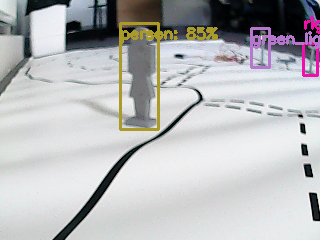

In [36]:
im = Image.open(input_image)
im.thumbnail((512, 512), Image.LANCZOS)
im.save("temp.png", "PNG")

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

threshold = 0.3

detection_result_image = run_odt_and_draw_results(
    "temp.png", interpreter, threshold=threshold
)

Image.fromarray(detection_result_image)